In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
                            median_absolute_error, mean_absolute_percentage_error
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools

import warnings
warnings.filterwarnings("ignore")

def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

def datatransform(data):
    data['Data'] = pd.to_datetime(data['Data'],dayfirst=True)
    data = data.sort_values('Data',ascending=True)
    data = data.groupby(pd.Grouper(key='Data', freq='1D')).mean()
    data = data.iloc[6: , :]  # seleziono i valori dal 08-09-2022
    for k in data.columns: 
        data[k].fillna(method='bfill',inplace=True)  # fill NaN with method bfill
    return data


In [8]:
# creazione dataframe

data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])

data['data'] = pd.to_datetime(data['data'], dayfirst=True)

data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)

data.set_index('date',inplace=True)

# perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()


# adding mean temperature and humidity of lombardy from 01/09/2020 to 03/09/2020

Bergamo_airport_ts = pd.read_csv('Weather/Bergamo_airport_ts.csv')
Bergamo_airport_ts = datatransform(Bergamo_airport_ts)

Brescia_airport_ts = pd.read_csv('Weather/Brescia_airport_ts.csv')
Brescia_airport_ts = datatransform(Brescia_airport_ts)

Milan_airport_ts = pd.read_csv('Weather/Milan_airport_ts.csv')
Milan_airport_ts = datatransform(Milan_airport_ts)

Milan_malpensa_ts = pd.read_csv('Weather/Milan_malpensa_ts.csv')
Milan_malpensa_ts = datatransform(Milan_malpensa_ts)

Milan_ts = pd.read_csv('Weather/Milan_ts.csv')
Milan_ts = datatransform(Milan_ts)

Piacenza_ts = pd.read_csv('Weather/Piacenza_ts.csv')
Piacenza_ts = datatransform(Piacenza_ts)

Verona_ts = pd.read_csv('Weather/Verona_ts.csv')
Verona_ts = datatransform(Verona_ts)

dataframe = [Bergamo_airport_ts,
Brescia_airport_ts,
Milan_airport_ts,
Milan_malpensa_ts,
Milan_ts,
Piacenza_ts,
Verona_ts]

temp_ts = pd.DataFrame()
umid_ts = pd.DataFrame()
final_ts = pd.DataFrame()

num = 0
for i in dataframe:
    temp_ts['Temperatura '+str(num)] = i.Temperatura
    num += 1 
    
num = 0
for i in dataframe:
    umid_ts['Umidutà '+str(num)] = i.Umidità
    num += 1 


final_ts['Temperatura_media'] =  temp_ts.sum(axis=1)/len(temp_ts.columns)
final_ts['Umidità_media'] = umid_ts.sum(axis=1)/len(temp_ts.columns)

for i in final_ts:
    data[i] = final_ts[i]
    
data = data[data.index <= '2022-09-03']

data

,perc_oggi,ospedalizzati_oggi,Temperatura_media,Umidità_media
date,,,,
2020-09-07,1.460000,268.0,20.981416,79.769909
2020-09-08,1.432857,275.0,21.696111,71.287302
2020-09-09,1.380000,279.0,22.247918,70.887285
2020-09-10,1.350000,286.0,22.795952,73.563690
2020-09-11,1.378571,273.0,23.065238,72.722619
...,...,...,...,...
2022-08-30,14.430000,680.0,24.902930,73.119505
2022-08-31,14.257143,655.0,23.088153,76.984631
2022-09-01,14.020000,627.0,23.094048,70.111264



________________
new subset training n 1: 
['perc_oggi', 'Temperatura_media', 'Umidità_media']



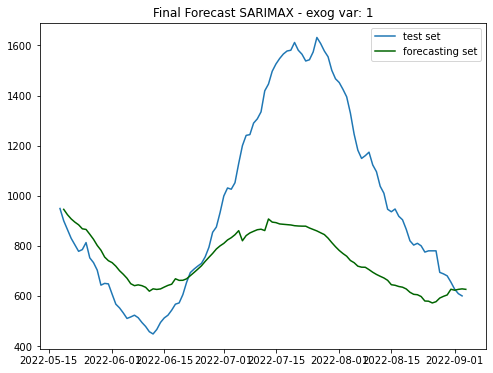


Error on test SARIMAX - exog var: 1:['perc_oggi', 'Temperatura_media', 'Umidità_media']
Mean Squared Error: 141276.4575
Root Mean Sqarred Error: 375.8676
Mean Absolute Error: 286.4897
Mean Absolute Percentage Error: 25.8531
_________________

________________
new subset training n 2: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek']



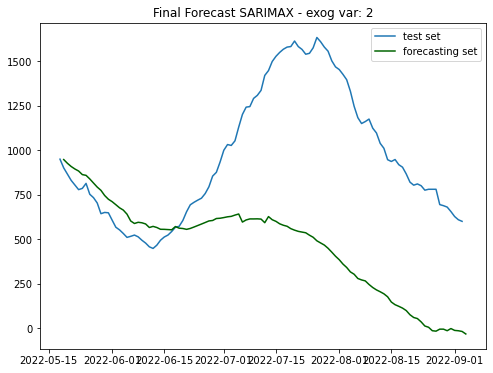


Error on test SARIMAX - exog var: 2:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek']
Mean Squared Error: 448872.1781
Root Mean Sqarred Error: 669.9792
Mean Absolute Error: 538.3196
Mean Absolute Percentage Error: 50.4863
_________________

________________
new subset training n 3: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter']



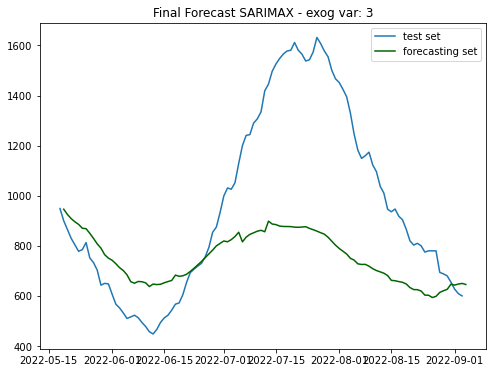


Error on test SARIMAX - exog var: 3:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter']
Mean Squared Error: 140366.1409
Root Mean Sqarred Error: 374.6547
Mean Absolute Error: 286.9602
Mean Absolute Percentage Error: 26.161
_________________

________________
new subset training n 4: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day']



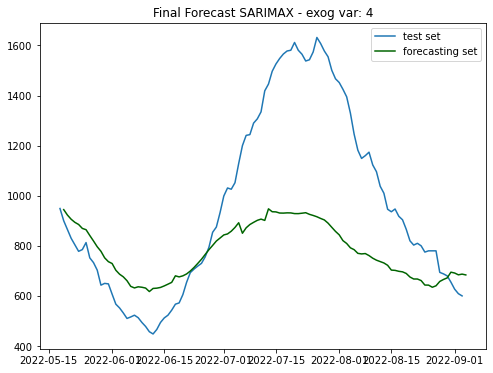


Error on test SARIMAX - exog var: 4:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day']
Mean Squared Error: 116952.3301
Root Mean Sqarred Error: 341.9829
Mean Absolute Error: 259.17
Mean Absolute Percentage Error: 23.5184
_________________

________________
new subset training n 5: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'weekofyear']



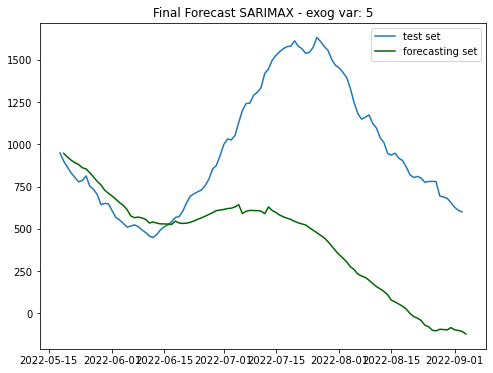


Error on test SARIMAX - exog var: 5:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'weekofyear']
Mean Squared Error: 491154.4314
Root Mean Sqarred Error: 700.8241
Mean Absolute Error: 560.2207
Mean Absolute Percentage Error: 52.6531
_________________

________________
new subset training n 6: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'month']



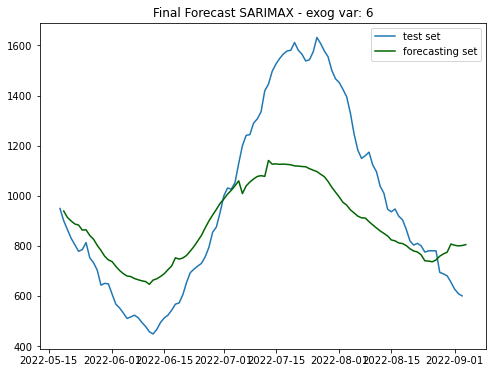


Error on test SARIMAX - exog var: 6:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'month']
Mean Squared Error: 62601.855
Root Mean Sqarred Error: 250.2036
Mean Absolute Error: 200.1084
Mean Absolute Percentage Error: 20.3542
_________________

________________
new subset training n 7: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter']



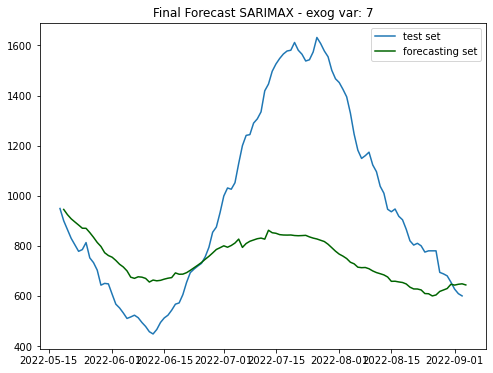


Error on test SARIMAX - exog var: 7:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter']
Mean Squared Error: 152784.3279
Root Mean Sqarred Error: 390.8764
Mean Absolute Error: 299.978
Mean Absolute Percentage Error: 27.4486
_________________

________________
new subset training n 8: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'day']



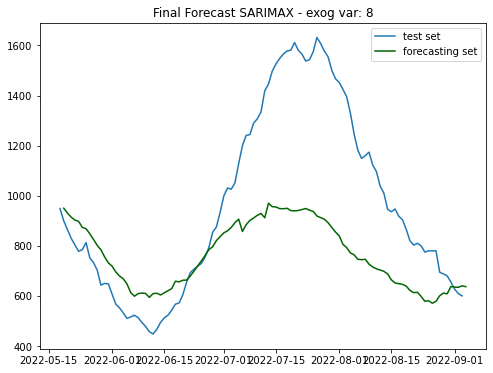


Error on test SARIMAX - exog var: 8:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'day']
Mean Squared Error: 118435.3703
Root Mean Sqarred Error: 344.1444
Mean Absolute Error: 261.7483
Mean Absolute Percentage Error: 23.5475
_________________

________________
new subset training n 9: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'weekofyear']



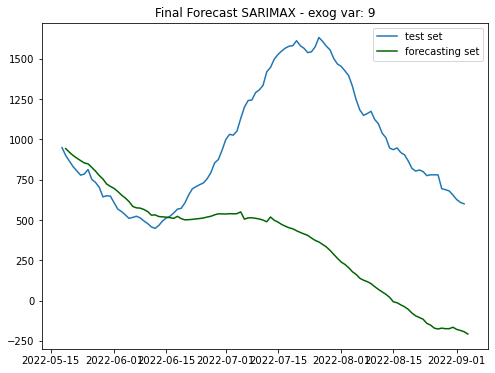


Error on test SARIMAX - exog var: 9:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'weekofyear']
Mean Squared Error: 599777.703
Root Mean Sqarred Error: 774.4532
Mean Absolute Error: 621.7646
Mean Absolute Percentage Error: 58.391
_________________

________________
new subset training n 10: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'month']



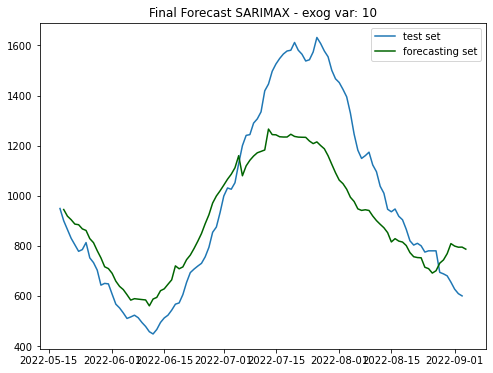


Error on test SARIMAX - exog var: 10:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'month']
Mean Squared Error: 39773.445
Root Mean Sqarred Error: 199.4328
Mean Absolute Error: 162.768
Mean Absolute Percentage Error: 16.4089
_________________

________________
new subset training n 11: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day']



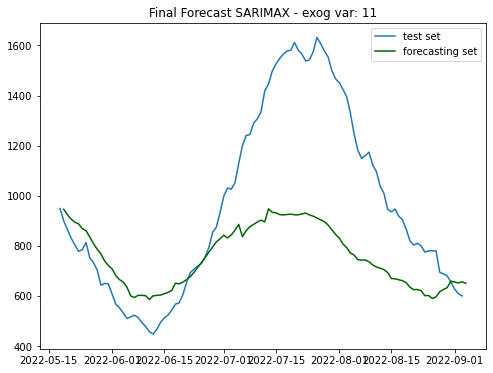


Error on test SARIMAX - exog var: 11:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day']
Mean Squared Error: 121780.4462
Root Mean Sqarred Error: 348.9706
Mean Absolute Error: 261.582
Mean Absolute Percentage Error: 23.1538
_________________

________________
new subset training n 12: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'weekofyear']



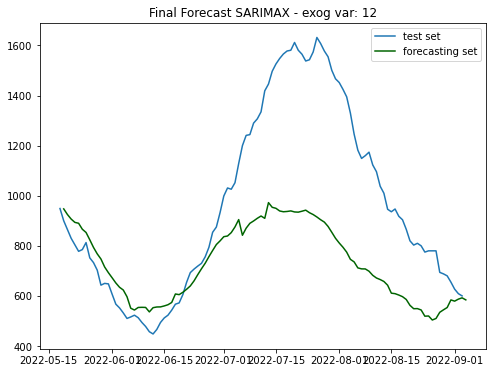


Error on test SARIMAX - exog var: 12:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'weekofyear']
Mean Squared Error: 127292.9234
Root Mean Sqarred Error: 356.7813
Mean Absolute Error: 265.9658
Mean Absolute Percentage Error: 23.0718
_________________

________________
new subset training n 13: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'month']



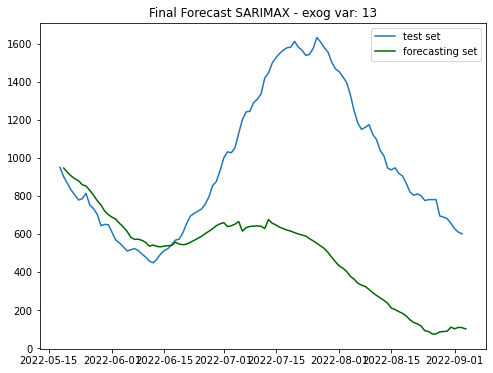


Error on test SARIMAX - exog var: 13:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'month']
Mean Squared Error: 389184.3725
Root Mean Sqarred Error: 623.8464
Mean Absolute Error: 496.3921
Mean Absolute Percentage Error: 45.7907
_________________

________________
new subset training n 14: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day', 'weekofyear']



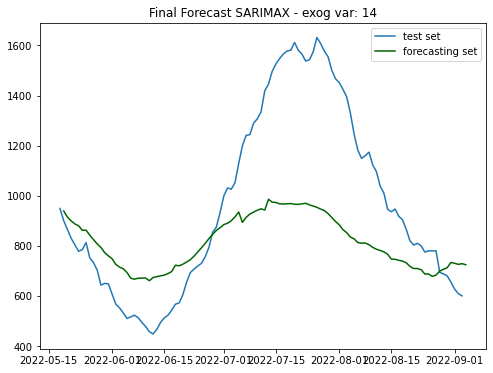


Error on test SARIMAX - exog var: 14:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day', 'weekofyear']
Mean Squared Error: 102887.7547
Root Mean Sqarred Error: 320.7612
Mean Absolute Error: 248.7571
Mean Absolute Percentage Error: 23.6709
_________________

________________
new subset training n 15: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day', 'month']



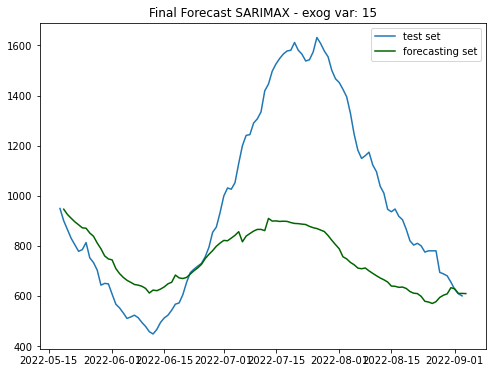


Error on test SARIMAX - exog var: 15:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day', 'month']
Mean Squared Error: 140096.199
Root Mean Sqarred Error: 374.2943
Mean Absolute Error: 286.1311
Mean Absolute Percentage Error: 25.8602
_________________

________________
new subset training n 16: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'weekofyear', 'month']



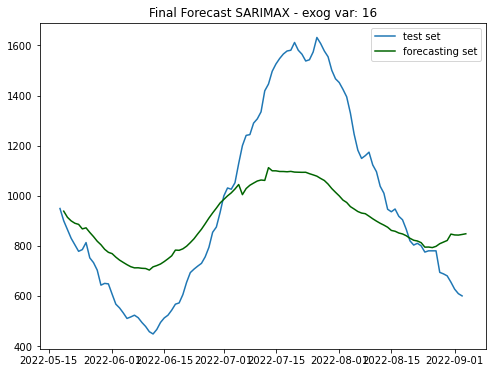


Error on test SARIMAX - exog var: 16:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'weekofyear', 'month']
Mean Squared Error: 69097.8937
Root Mean Sqarred Error: 262.8648
Mean Absolute Error: 211.859
Mean Absolute Percentage Error: 22.3955
_________________

________________
new subset training n 17: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day']



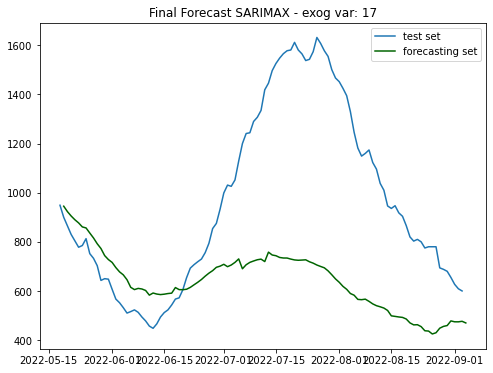


Error on test SARIMAX - exog var: 17:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day']
Mean Squared Error: 227072.5714
Root Mean Sqarred Error: 476.5213
Mean Absolute Error: 370.8738
Mean Absolute Percentage Error: 33.1214
_________________

________________
new subset training n 18: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'weekofyear']



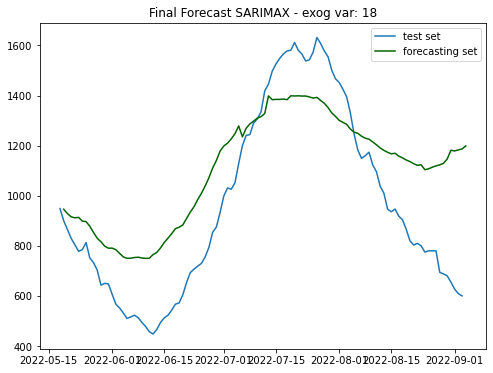


Error on test SARIMAX - exog var: 18:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'weekofyear']
Mean Squared Error: 60683.5981
Root Mean Sqarred Error: 246.3404
Mean Absolute Error: 211.9983
Mean Absolute Percentage Error: 28.3659
_________________

________________
new subset training n 19: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'month']



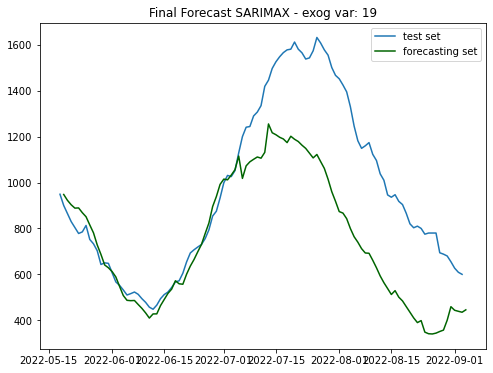


Error on test SARIMAX - exog var: 19:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'month']
Mean Squared Error: 97510.3592
Root Mean Sqarred Error: 312.2665
Mean Absolute Error: 235.018
Mean Absolute Percentage Error: 21.965
_________________

________________
new subset training n 20: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'day', 'weekofyear']



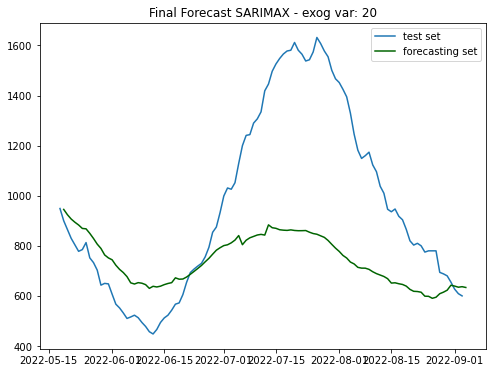


Error on test SARIMAX - exog var: 20:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'day', 'weekofyear']
Mean Squared Error: 146523.2517
Root Mean Sqarred Error: 382.7836
Mean Absolute Error: 291.5862
Mean Absolute Percentage Error: 26.3328
_________________

________________
new subset training n 21: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'day', 'month']



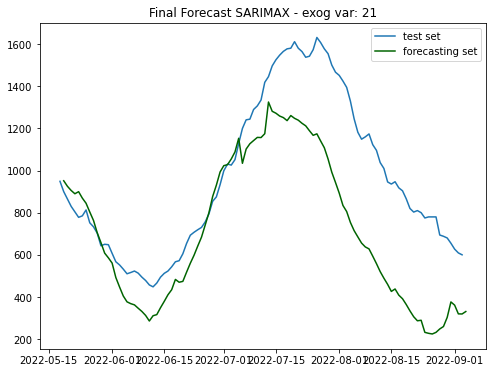


Error on test SARIMAX - exog var: 21:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'day', 'month']
Mean Squared Error: 116668.3362
Root Mean Sqarred Error: 341.5675
Mean Absolute Error: 272.1982
Mean Absolute Percentage Error: 28.5125
_________________

________________
new subset training n 22: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'weekofyear', 'month']



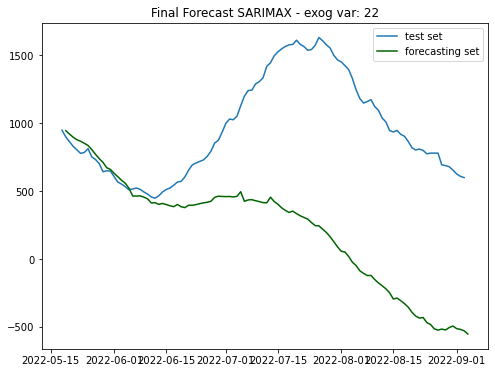


Error on test SARIMAX - exog var: 22:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'weekofyear', 'month']
Mean Squared Error: 866751.4845
Root Mean Sqarred Error: 930.9949
Mean Absolute Error: 749.8931
Mean Absolute Percentage Error: 72.3578
_________________

________________
new subset training n 23: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'weekofyear']



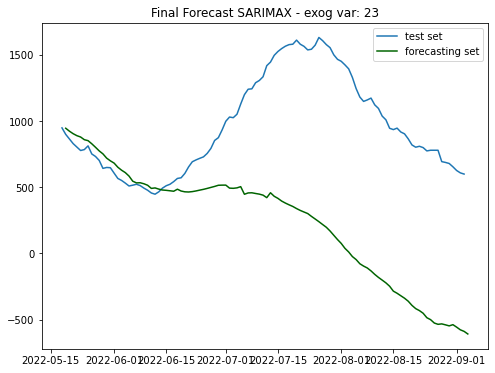


Error on test SARIMAX - exog var: 23:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'weekofyear']
Mean Squared Error: 864239.5947
Root Mean Sqarred Error: 929.6449
Mean Absolute Error: 740.4117
Mean Absolute Percentage Error: 71.0365
_________________

________________
new subset training n 24: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'month']



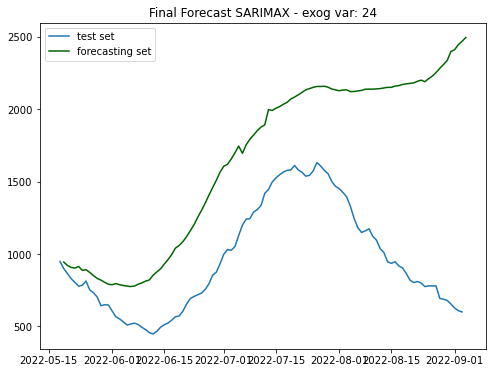


Error on test SARIMAX - exog var: 24:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'month']
Mean Squared Error: 692350.2617
Root Mean Sqarred Error: 832.0759
Mean Absolute Error: 691.6591
Mean Absolute Percentage Error: 80.9987
_________________

________________
new subset training n 25: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'weekofyear', 'month']



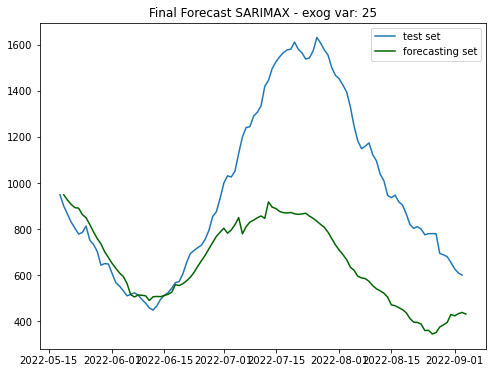


Error on test SARIMAX - exog var: 25:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'weekofyear', 'month']
Mean Squared Error: 183682.6932
Root Mean Sqarred Error: 428.5822
Mean Absolute Error: 326.7713
Mean Absolute Percentage Error: 28.7234
_________________

________________
new subset training n 26: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day', 'weekofyear', 'month']



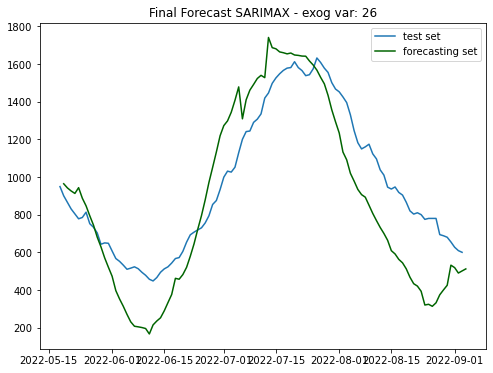


Error on test SARIMAX - exog var: 26:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day', 'weekofyear', 'month']
Mean Squared Error: 63355.1822
Root Mean Sqarred Error: 251.7046
Mean Absolute Error: 218.1072
Mean Absolute Percentage Error: 26.0909
_________________

________________
new subset training n 27: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear']



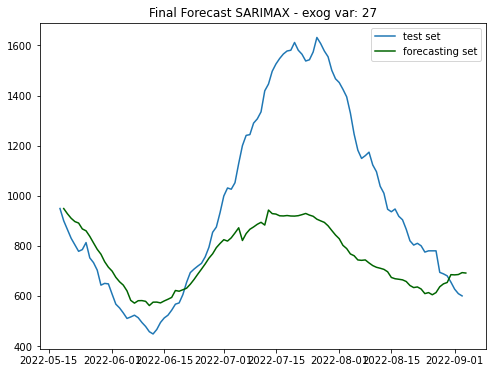


Error on test SARIMAX - exog var: 27:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear']
Mean Squared Error: 122565.7203
Root Mean Sqarred Error: 350.0939
Mean Absolute Error: 259.6564
Mean Absolute Percentage Error: 22.5517
_________________

________________
new subset training n 28: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']



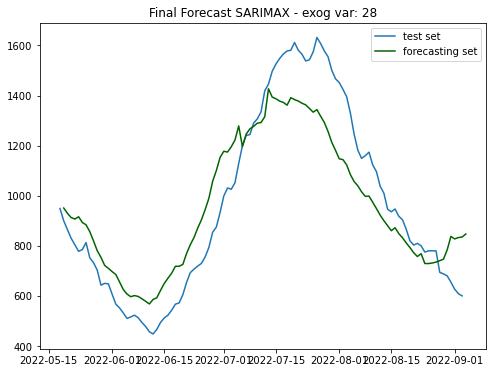


Error on test SARIMAX - exog var: 28:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']
Mean Squared Error: 27352.358
Root Mean Sqarred Error: 165.3855
Mean Absolute Error: 140.9868
Mean Absolute Percentage Error: 15.7326
_________________

________________
new subset training n 29: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'weekofyear', 'month']



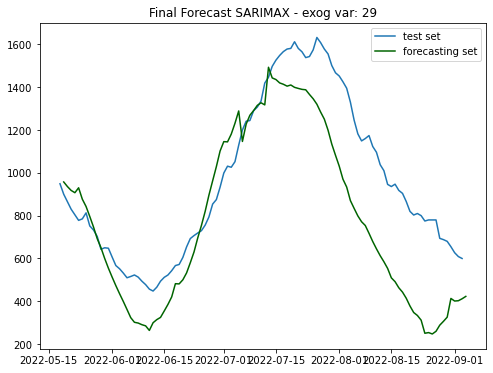


Error on test SARIMAX - exog var: 29:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'weekofyear', 'month']
Mean Squared Error: 82258.6934
Root Mean Sqarred Error: 286.8078
Mean Absolute Error: 230.8006
Mean Absolute Percentage Error: 25.8167
_________________

________________
new subset training n 30: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'day', 'weekofyear', 'month']



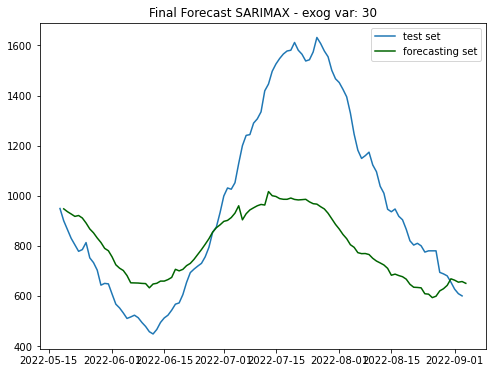


Error on test SARIMAX - exog var: 30:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'day', 'weekofyear', 'month']
Mean Squared Error: 105493.2155
Root Mean Sqarred Error: 324.7972
Mean Absolute Error: 255.9757
Mean Absolute Percentage Error: 24.2168
_________________

________________
new subset training n 31: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'weekofyear', 'month']



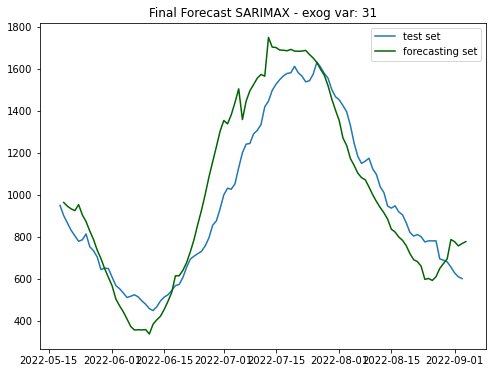


Error on test SARIMAX - exog var: 31:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'weekofyear', 'month']
Mean Squared Error: 30975.9361
Root Mean Sqarred Error: 175.9998
Mean Absolute Error: 145.5448
Mean Absolute Percentage Error: 16.2161
_________________

________________
new subset training n 32: 
['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear', 'month']



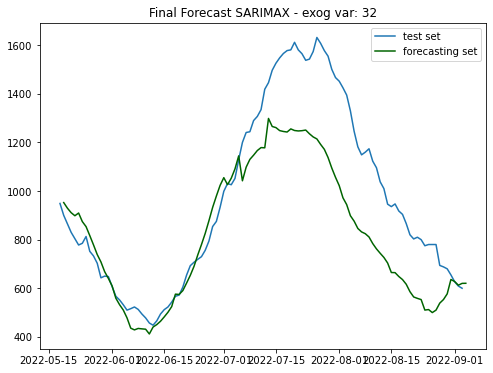


Error on test SARIMAX - exog var: 32:['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear', 'month']
Mean Squared Error: 53426.267
Root Mean Sqarred Error: 231.1412
Mean Absolute Error: 175.4485
Mean Absolute Percentage Error: 16.1048
_________________


In [11]:
# "manual" loop in order to search the best combination of feature selection 

feat_extr_diz = {
    'dayofweek':data.index.dayofweek,
    'quarter':data.index.quarter,
    'day':data.index.day,
    'weekofyear':data.index.weekofyear,
    'month':data.index.month,
}


error = {}

stuff = feat_extr_diz.keys()
number = 1
for L in range(len(stuff) + 1):
    for subset in itertools.combinations(stuff, L):
        print(f'\n________________\nnew subset training n {number}: ')
        data_loop = data.copy()
        for i in list(subset):    
            data_loop[i] = feat_extr_diz[i]
            
        print(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns))
        print()
        
        # perc shifted by 7 d in future
        data_loop.perc_oggi = data_loop.perc_oggi.shift(7).fillna(method='bfill')
        data_loop.Umidità_media = data_loop.Umidità_media.shift(7).fillna(method='bfill')
        data_loop.Temperatura_media = data_loop.Temperatura_media.shift(7).fillna(method='bfill')

        
        # y ospedalizzati
        series = data_loop.ospedalizzati_oggi

        # splitting test and train
        len_train_train_test = int(len(series.index)-len(series.index)*15/100)
        index_train_test = list(data_loop.index)[len_train_train_test]

        # y test and y train
        y_train = series[series.index <= index_train_test]
        y_test = series[series.index > index_train_test]

        # X exog df
        exog_col = list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)  
        exogen_train = data_loop[exog_col][data_loop.index <= index_train_test]
        exogen_test = data_loop[exog_col][data_loop.index > index_train_test]
        
        # prediction df after training
        df_exog_prediction = data_loop[exog_col][data_loop.index >= data_loop.index[-7]].reset_index(drop=True)
        df_exog_prediction['date'] = pd.date_range(start=exogen_test.index[-1]+timedelta(1),periods=7,freq='D')
        df_exog_prediction.set_index('date',inplace=True)
    
    
    
    
        # -> SARIMAX Model train/test
        sxmodel = pm.auto_arima(y_train.values.reshape(-1, 1), 
                                    exogenous = exogen_train.values.reshape(-1,len(exog_col)),
                                    start_p=1, start_q=1, d=None,
                                    max_p=5, max_q=5,
                                    start_P=0, start_Q=0, D=None,
                                    seasonal=True,
                                    m = 7,
                                    test='adf',
                                    n_jobs=-1,
                                    trace=False,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)


        # Forecast
        n_periods = len(y_test)
        fitted_values, confint = sxmodel.predict(n_periods=n_periods, 
                                              exogenous = exogen_test.values.reshape(-1,len(exog_col)), 
                                              return_conf_int=True)
        index_of_fc = pd.date_range(y_test.index[1], periods = n_periods, freq='D')
        fitted_series_test = pd.Series(fitted_values, index=index_of_fc)

        # Plot
        plt.figure(figsize=(8,6))
        plt.plot(y_test,label='test set')
        plt.plot(fitted_series_test, color='darkgreen',label='forecasting set')
        plt.legend()
        title = "Final Forecast SARIMAX - exog var: " + str(number)
        plt.title(title)
        plt.show()
        
        # error
        print(f'\nError on test SARIMAX - exog var: {number}:' + str(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)))
        calcError(y_test,fitted_series_test)

        RMSE = sqrt(mean_squared_error(y_test, fitted_series_test))
        MAPE = mean_absolute_percentage_error(y_test, fitted_series_test)
        
        error[number]= [round(RMSE,4),
                        str(list(data_loop.drop('ospedalizzati_oggi',axis=1).columns)),
                        round(MAPE,4)]
        
        number = number + 1
        print('_________________')
              


In [25]:
# best model by rmse; 
result_error = pd.DataFrame(error.values(),index=error.keys())
result_error.rename(columns={0:'rmse',1:'features',2:'mape'},inplace=True)
pd.set_option('max_colwidth', 800)
result_error.sort_values(by='rmse',ascending=True)

,rmse,features,mape
28,165.3855,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']",0.1573
31,175.9998,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'weekofyear', 'month']",0.1622
10,199.4328,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'month']",0.1641
32,231.1412,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear', 'month']",0.1610
18,246.3404,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'weekofyear']",0.2837
6,250.2036,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'month']",0.2035
26,251.7046,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'day', 'weekofyear', 'month']",0.2609
16,262.8648,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'weekofyear', 'month']",0.2240
29,286.8078,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'weekofyear', 'month']",0.2582
19,312.2665,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'month']",0.2197


In [26]:
# best model by mape
pd.set_option('max_colwidth', 800)
result_error.sort_values(by='mape',ascending=True)


,rmse,features,mape
28,165.3855,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']",0.1573
32,231.1412,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear', 'month']",0.1610
31,175.9998,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day', 'weekofyear', 'month']",0.1622
10,199.4328,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'month']",0.1641
6,250.2036,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'month']",0.2035
19,312.2665,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'month']",0.2197
16,262.8648,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'weekofyear', 'month']",0.2240
27,350.0939,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'weekofyear']",0.2255
12,356.7813,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'weekofyear']",0.2307
11,348.9706,"['perc_oggi', 'Temperatura_media', 'Umidità_media', 'quarter', 'day']",0.2315


In [14]:
# -> best model rmse: ['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']
# -> best model mape: ['perc_oggi', 'Temperatura_media', 'Umidità_media', 'dayofweek', 'quarter', 'day', 'month']

def timeserieFeatureExtractor_best(timeseries):
    timeseries['dayofweek'] = timeseries.index.dayofweek
    timeseries['quarter'] = timeseries.index.quarter
    timeseries['day'] = timeseries.index.day
    timeseries['month'] = timeseries.index.month
    timeseries.fillna(0,inplace=True)
    return 

data = data[data.index <= '2022-09-03']

# y series
series = pd.DataFrame(data.ospedalizzati_oggi)

# exogen series 
exog_series = data.drop('ospedalizzati_oggi',axis=1)

# feature extraction
timeserieFeatureExtractor_best(exog_series)

# exogen series (prediction)
exog_df_prediction = pd.DataFrame(exog_series[exog_series.index >= exog_series.index[-7]])

# perc shifted by 7 d in future
exog_series.perc_oggi = exog_series.perc_oggi.shift(7).fillna(method='bfill')
exog_series.Umidità_media = exog_series.Umidità_media.shift(7).fillna(method='bfill')
exog_series.Temperatura_media = exog_series.Temperatura_media.shift(7).fillna(method='bfill')


In [15]:
# -> SARIMAX Model on all ts
sxmodel_all = pm.auto_arima(series.values.reshape(-1, 1), 
                                    exogenous = exog_series.values.reshape(-1,len(exog_series.columns)),
                                    start_p=1, start_q=1, d=None,
                                    max_p=5, max_q=5,
                                    start_P=0, start_Q=0, D=None,
                                    seasonal=True,
                                    m = 7,
                                    test='adf',
                                    n_jobs=-1,
                                    trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=7808.384, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8435.554, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7831.267, Time=1.73 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8079.535, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8433.965, Time=0.51 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=7724.845, Time=2.34 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=7731.325, Time=3.36 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=7754.182, Time=1.93 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=7925.580, Time=1.58 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=7791.139, Time=2.15 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=7797.835, Time=1.99 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=8015.213, Time=1.58 sec
 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=7

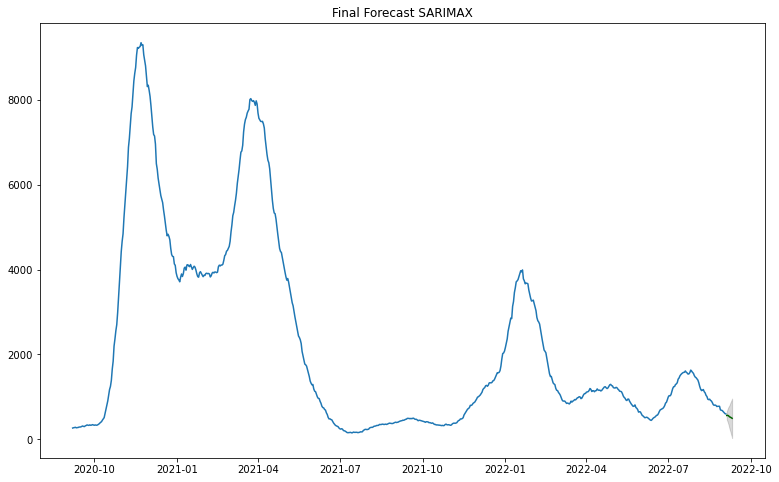

In [16]:
# Forecast
n_periods = 7
fitted_values, confint = sxmodel_all.predict(n_periods=n_periods, 
                                  exogenous=exog_df_prediction.values.reshape(-1,len(exog_df_prediction.columns)), 
                                  return_conf_int=True)



index_of_fc = pd.date_range(series.index[-1]+timedelta(days=1), periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted_values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(13,8))
plt.plot(series)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast SARIMAX")
plt.show()

In [17]:
# df prediction of sarimax trained on all data
fitted_series

2022-09-04    564.298526
2022-09-05    566.720047
2022-09-06    557.731316
2022-09-07    531.714318
2022-09-08    524.523766
2022-09-09    510.285549
2022-09-10    497.129117
Freq: D, dtype: float64